In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import data_tools.graphs as gt
from hetnet_ml.extractor import MatrixFormattedGraph

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
man_dir = Path('../0_data/manual/').resolve()
load_dir = Path('../2_pipeline/13a_Model_Prep_Holdout_Set/out/').resolve()

In [3]:
nodes = pd.read_csv(load_dir.joinpath('nodes.csv'), dtype=str)
edges = pd.read_csv(load_dir.joinpath('edges.csv'), dtype=str)

In [4]:
nodes.head(2)

,id,name,label,xrefs,source,synonyms,alt_ids,subsets
0,UBERON:0000002,cervix,AnatomicalEntity,MESH:D002584|UBERON:0000002,NaN,NaN,NaN,NaN
1,UBERON:0000004,human nose,AnatomicalEntity,MESH:D009666|UBERON:0000004,NaN,NaN,NaN,NaN


In [5]:
mps = gt.dataframes_to_metagraph(nodes, edges).extract_metapaths('ChemicalSubstance', 'Disease', 4)
mps = [mp for mp in mps if len(mp) > 1]
len(mps)

17277

In [6]:
mps = [mp for mp in mps if len(mp) > 1]

In [7]:
mps[0]

CpoAawD

In [8]:
e_info = pd.read_csv(man_dir.joinpath('edge_semtypes.csv'))
directed_map = e_info.set_index('fwd_edge')['directed']

In [9]:
similarity_paths_check = []

for mp in tqdm(mps):
    if len(mp) < 2:
        similarity_paths_check.append(True)
        continue
    this_path = []
    for label in ['ChemicalSubstance']:
        this_path.append(gt.is_similarity(mp, ['ChemicalSubstance'], directed_map))
    this_path.append(gt.is_similarity(mp, 'Disease', directed_map, max_repeats=1))
    
    # Don't want CtXaYzD edges.. Ct (and Cm) edges should be banned...
    # Though not strictly similarity edges, they have heavy implications for Disease Phenotype similarity
    bl_edge = ['Ct', 'Cm', 'Cdg', 'Cpl', 'Cpv']
    for bl in bl_edge:
        if mp.abbrev.startswith(bl) or mp.abbrev.endswith('aw'+bl+'D'):
            this_path.append(True)
    
    similarity_paths_check.append(sum(this_path) > 0)

In [10]:
non_sim_mps = [mp for mp, sim in zip(mps, similarity_paths_check) if not sim]
len(non_sim_mps)

8284

In [17]:
'{:%}'.format(len(non_sim_mps) / len(mps))

'47.948139%'

## Routine for extracting information

In [18]:
from copy import deepcopy

def piecewise_extraction(function, to_split, block_size=1000, **params):
    
    assert type(to_split) == str and to_split in params
    
    # Won't want progress bars for each subsetx
    params['verbose'] = False
    
    # Retain a copy of the original parameters
    full_params = deepcopy(params)    
    total = len(params[to_split])
    
    # Determine the number of iterations needed
    num_iter = total // block_size
    if total % block_size != 0:
        num_iter += 1
    
    all_results = []
    for i in tqdm(range(num_iter)):
        
        # Get the start and end indicies
        start = i * block_size
        end = (i+1) * block_size
        
        # End can't be larger than the total number items
        if end > total:
            end = total
        
        # Subset the paramter of interest
        params[to_split] = full_params[to_split][start: end]
        
        # Get the funciton results
        all_results.append(function(**params))
    
    return pd.concat(all_results, sort=False, ignore_index=True)

In [19]:
mg = MatrixFormattedGraph(nodes, edges, 'ChemicalSubstance', 'Disease', max_length=4, w=0.4, n_jobs=30)

Processing node and edge data...
Initializing metagraph...
Generating adjacency matrices...


100%|██████████| 68/68 [00:55<00:00,  1.22it/s]



Determining degrees for each node and metaedge


100%|██████████| 68/68 [00:27<00:00,  2.47it/s]



Weighting matrices by degree with dampening factor 0.4...


100%|██████████| 68/68 [00:01<00:00, 55.97it/s]


# Memory requirement estimates

## Estimate on memory required to extract all Compound-Disease Pairs

In [20]:
float_size = 32 # bits
bits_per_gb = 8589934592

def print_mem_info(n_comp, n_dis, n_mps):
    print("{:,} Compounds * {:,} Diseases = {:,} C-D Pairs".format(n_comp, n_dis,
                                                                   n_comp * n_dis))
    print("{:,} C-D Pairs * {:,} Metapaths = {:,} Matrix Values".format(n_comp * n_dis,
                                                                    n_mps, 
                                                                    n_comp * n_dis * n_mps))

    print('{:1,.1f} GB of matrix values'.format(n_comp * n_dis * n_mps * float_size / (bits_per_gb)))
    
    print('{:1,.3f} GB per metapath'.format(n_comp * n_dis * float_size / (bits_per_gb)))

In [21]:
total_comps = nodes['label'].value_counts()['ChemicalSubstance']
total_dis = nodes['label'].value_counts()['Disease']


print_mem_info(total_comps, total_dis, len(non_sim_mps))

40,766 Compounds * 13,961 Diseases = 569,134,126 C-D Pairs
569,134,126 C-D Pairs * 8,284 Metapaths = 4,714,707,099,784 Matrix Values
17,563.7 GB of matrix values
2.120 GB per metapath


In [22]:
%%time
all_mp_counts = []

mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=200,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes='ChemicalSubstance', 
                                 end_nodes='Disease', 
                                 n_jobs=30)

mp_counts['subset'] = 'all_pairs'
mp_counts['frac'] = mp_counts['pair_count'] / (total_comps*total_dis)
all_mp_counts.append(mp_counts)


CPU times: user 17min 57s, sys: 8min 54s, total: 26min 51s
Wall time: 2h 3min 12s


In [23]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CpoAawD,5854758,all_pairs,0.010287
1,CpoAsoD,0,all_pairs,0.000000


In [24]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 86.24%'

## All potential training Positives

In [25]:
keep_comps = set(edges.query('type == "treats_CtD"')['start_id'])
keep_dis = set(edges.query('type == "treats_CtD"')['end_id'])

print_mem_info(len(keep_comps), len(keep_dis), len(non_sim_mps))

9,042 Compounds * 5,326 Diseases = 48,157,692 C-D Pairs
48,157,692 C-D Pairs * 8,284 Metapaths = 398,938,320,528 Matrix Values
1,486.2 GB of matrix values
0.179 GB per metapath


In [26]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=500,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(keep_comps), 
                                 end_nodes=list(keep_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'all_pos'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 6min 40s, sys: 4min, total: 10min 40s
Wall time: 1h 1min 28s


In [27]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CpoAawD,523268,all_pos,0.010866
1,CpoAsoD,0,all_pos,0.000000


In [28]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 84.64%'

## Reframe Compounds and Reframe Treated Diseases



In [29]:
ref_c = nodes.dropna(subset=['source'])['id'].tolist()
len(ref_c)

5970

In [30]:
keep_comps = set(ref_c)
keep_dis = set(edges.query('start_id in @ref_c and type == "treats_CtD"')['end_id'])

print_mem_info(len(keep_comps), len(keep_dis), len(non_sim_mps))

5,970 Compounds * 4,829 Diseases = 28,829,130 C-D Pairs
28,829,130 C-D Pairs * 8,284 Metapaths = 238,820,512,920 Matrix Values
889.7 GB of matrix values
0.107 GB per metapath


In [31]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=1000,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(keep_comps), 
                                 end_nodes=list(keep_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'reframe'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 4min 40s, sys: 2min 29s, total: 7min 10s
Wall time: 49min 16s


In [32]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CpoAawD,435804,reframe,0.015117
1,CpoAsoD,0,reframe,0.000000


In [33]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 82.77%'

## Ideal Training Subset

Ideally we need all compounds and diseases associated with training positives, as well as some negatives.

In [34]:
neg_frac = 0.1
rs = 1234


keep_comps = set(edges.query('type == "treats_CtD"')['start_id'])
keep_comps = (keep_comps | set(nodes.query('id not in @keep_comps and label == "ChemicalSubstance"')
                                    .sample(frac=neg_frac, random_state=rs)['id']))

keep_dis =  set(edges.query('type == "treats_CtD"')['end_id'])
keep_dis = (keep_dis | set(nodes.query('label == "Disease" and id not in @keep_dis')
                                .sample(frac=neg_frac, random_state=rs+1)['id']))

In [35]:
print_mem_info(len(keep_comps), len(keep_dis), len(non_sim_mps))

12,214 Compounds * 6,190 Diseases = 75,604,660 C-D Pairs
75,604,660 C-D Pairs * 8,284 Metapaths = 626,309,003,440 Matrix Values
2,333.2 GB of matrix values
0.282 GB per metapath


In [36]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=1000,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(keep_comps), 
                                 end_nodes=list(keep_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'traning_sample'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 5min 34s, sys: 2min 40s, total: 8min 14s
Wall time: 57min 20s


In [37]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CpoAawD,794709,traning_sample,0.010511
1,CpoAsoD,0,traning_sample,0.000000


In [38]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 84.93%'

##  All Training Negatives

Lastly, lets take a look at all of the potnetial training negatives.  As these are compounds or diseases with no known treatments, its likely that there will be less informaiton known about them

In [39]:
pos_comps = set(edges.query('type == "treats_CtD"')['start_id'])
pos_dis = set(edges.query('type == "treats_CtD"')['end_id'])

neg_comps = set(nodes.query('label == "ChemicalSubstance"')['id']) - pos_comps
neg_dis = set(nodes.query('label == "Disease"')['id']) - pos_dis

print_mem_info(len(neg_comps), len(neg_dis), len(non_sim_mps))

31,724 Compounds * 8,635 Diseases = 273,936,740 C-D Pairs
273,936,740 C-D Pairs * 8,284 Metapaths = 2,269,291,954,160 Matrix Values
8,453.8 GB of matrix values
1.020 GB per metapath


In [40]:
%%time
mp_counts = piecewise_extraction(function=mg.extract_metapath_pair_counts, 
                                 to_split='metapaths', block_size=350,
                                 metapaths=[mp.abbrev for mp in mps], 
                                 start_nodes=list(neg_comps), 
                                 end_nodes=list(neg_dis), 
                                 n_jobs=30)

mp_counts['subset'] = 'negative_pairs'
mp_counts['frac'] = mp_counts['pair_count'] / (len(keep_comps)*len(keep_dis))
all_mp_counts.append(mp_counts)


CPU times: user 10min 40s, sys: 4min 44s, total: 15min 24s
Wall time: 1h 10min 32s


In [41]:
mp_counts.head(2)

,mp,pair_count,subset,frac
0,CpoAawD,2679265,negative_pairs,0.035438
1,CpoAsoD,0,negative_pairs,0.000000


In [42]:
'Percent of paths populated: {:1.2%}'.format((mp_counts['pair_count'] != 0).sum() / len(mp_counts))

'Percent of paths populated: 72.14%'

## Plot some of the results

In [43]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from data_tools.plotting import count_plot_h

In [44]:
non_sim_mp_names = [mp.abbrev for mp in non_sim_mps]

all_mp_counts = pd.concat(all_mp_counts, sort=False, ignore_index=True)
all_mp_counts['sim_mp'] = all_mp_counts['mp'].apply(lambda m: m not in non_sim_mp_names)

no_sim_mp_counts = all_mp_counts.query('sim_mp == False')
sim_mp_counts = all_mp_counts.query('sim_mp == True')

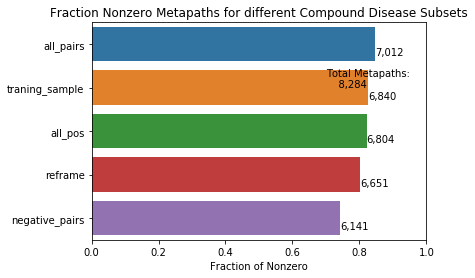

In [45]:
qr = no_sim_mp_counts.query('pair_count > 0')
frac = qr['subset'].value_counts() / no_sim_mp_counts['mp'].nunique()

count_plot_h(frac, qr['subset'].value_counts())
plt.xlim(0, 1)
plt.xlabel('Fraction of Nonzero')
plt.annotate('Total Metapaths:\n    {:,}'.format(no_sim_mp_counts['mp'].nunique()), (.7, 1))
plt.title('Fraction Nonzero Metapaths for different Compound Disease Subsets');

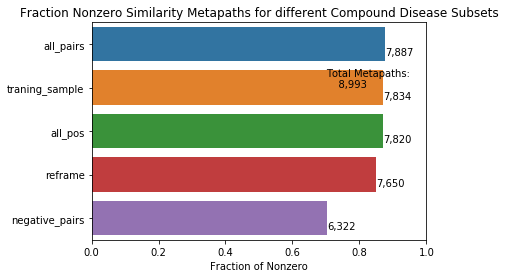

In [46]:
qr = sim_mp_counts.query('pair_count > 0')
frac = qr['subset'].value_counts() / sim_mp_counts['mp'].nunique()

count_plot_h(frac, qr['subset'].value_counts())
plt.xlim(0, 1)
plt.xlabel('Fraction of Nonzero')
plt.annotate('Total Metapaths:\n    {:,}'.format(sim_mp_counts['mp'].nunique()), (.7, 1))
plt.title('Fraction Nonzero Similarity Metapaths for different Compound Disease Subsets');

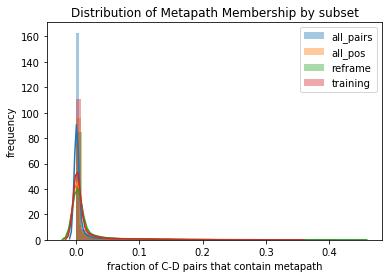

In [47]:
sns.distplot((no_sim_mp_counts.query('subset == "all_pairs" and frac > 0')['frac']), label='all_pairs');
sns.distplot((no_sim_mp_counts.query('subset == "all_pos" and frac > 0')['frac']), label='all_pos');
sns.distplot((no_sim_mp_counts.query('subset == "reframe" and frac > 0')['frac']), label='reframe');
sns.distplot((no_sim_mp_counts.query('subset == "traning_sample" and frac > 0')['frac']), label='training')
plt.legend()
plt.xlabel('fraction of C-D pairs that contain metapath')
plt.ylabel('frequency')
plt.title('Distribution of Metapath Membership by subset');

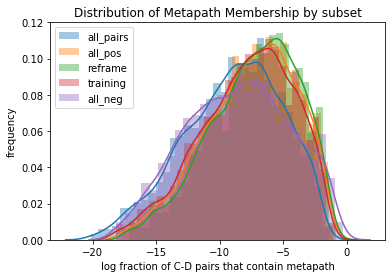

In [48]:
sns.distplot(np.log(no_sim_mp_counts.query('subset == "all_pairs" and frac > 0')['frac']), label='all_pairs');
sns.distplot(np.log(no_sim_mp_counts.query('subset == "all_pos" and frac > 0')['frac']), label='all_pos');
sns.distplot(np.log(no_sim_mp_counts.query('subset == "reframe" and frac > 0')['frac']), label='reframe');
sns.distplot(np.log(no_sim_mp_counts.query('subset == "traning_sample" and frac > 0')['frac']), label='training')
sns.distplot(np.log(no_sim_mp_counts.query('subset == "negative_pairs" and frac > 0')['frac']), label='all_neg')

plt.legend()
plt.xlabel('log fraction of C-D pairs that contain metapath')
plt.ylabel('frequency')
plt.title('Distribution of Metapath Membership by subset');

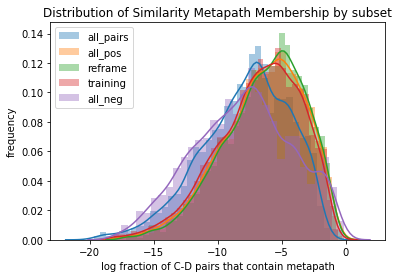

In [49]:
sns.distplot(np.log(sim_mp_counts.query('subset == "all_pairs" and frac > 0')['frac']), label='all_pairs');
sns.distplot(np.log(sim_mp_counts.query('subset == "all_pos" and frac > 0')['frac']), label='all_pos');
sns.distplot(np.log(sim_mp_counts.query('subset == "reframe" and frac > 0')['frac']), label='reframe');
sns.distplot(np.log(sim_mp_counts.query('subset == "traning_sample" and frac > 0')['frac']), label='training')
sns.distplot(np.log(sim_mp_counts.query('subset == "negative_pairs" and frac > 0')['frac']), label='all_neg')
plt.legend()
plt.xlabel('log fraction of C-D pairs that contain metapath')
plt.ylabel('frequency')
plt.title('Distribution of Similarity Metapath Membership by subset');

In [50]:
all_mp_counts.query('subset == "all_pairs"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
7265,CafGafCafBPawD,163596597,all_pairs,0.287448,True
7561,CafGmDawBPawD,163558373,all_pairs,0.287381,True
7228,CafGaCafBPawD,160728540,all_pairs,0.282409,True
7339,CafGinCafBPawD,160682629,all_pairs,0.282328,True
7266,CafGafCinBPawD,159381811,all_pairs,0.280043,True


In [51]:
no_sim_mp_counts.query('subset == "all_pairs"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
8155,CafGmPawBPawD,140827796,all_pairs,0.247442,False
430,CafGpoBPawD,116772468,all_pairs,0.205176,False
8151,CafGmPawAawD,114994835,all_pairs,0.202052,False
8127,CafGawPawBPawD,110329561,all_pairs,0.193855,False
7053,CafGpoApoGawD,108441980,all_pairs,0.190539,False


In [52]:
all_mp_counts.query('subset == "all_pos"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
22708,CtDawBPafCtD,41792564,all_pos,0.867827,True
22712,CtDawBPinCtD,40828495,all_pos,0.847808,True
22704,CtDawBPaCtD,40433596,all_pos,0.839608,True
23095,CtDawPWawCtD,39804906,all_pos,0.826553,True
22962,CtDmGafCtD,35125808,all_pos,0.729391,True


In [53]:
no_sim_mp_counts.query('subset == "all_pos"').sort_values('frac', ascending=False).head()

,mp,pair_count,subset,frac,sim_mp
25432,CafGmPawBPawD,18805383,all_pos,0.390496,False
24579,CafGrxCafBPawD,16186735,all_pos,0.336119,False
24329,CafGpoApoCtD,15878165,all_pos,0.329712,False
17707,CafGpoBPawD,15855634,all_pos,0.329244,False
24578,CafGrxCaBPawD,15639062,all_pos,0.324747,False


## Save out the information

In [54]:
this_file = '13b_Model_Prep_Metapath_Membership_Analysis'

out_dir = Path('../2_pipeline').joinpath(this_file).joinpath('out').resolve()
out_dir.mkdir(exist_ok=True, parents=True)

In [55]:
all_mp_counts.to_csv(out_dir.joinpath('all_mp_counts.csv'), index=False)